# Generates the readout's coefficients using the output from the simulations created in the notebook 2DofArm_simulation-Main.ipnb  

In [11]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

plt.rcParams['figure.figsize'] = 5, 10

import numpy
import sys
from sklearn import linear_model

import save_load_file as slf

import membrane_lowpass_md
reload(sys.modules['membrane_lowpass_md']) # Makes sure the interpreter is going to reload the module
membrane_lowpass = membrane_lowpass_md.membrane_lowpass

In [20]:
STP_ON="" #means "NO STP"
# STP_ON="_STP_ON" #means "USING STP"
membrane_time_constant = 30E-3
using_spikes = 0 #controls if the output is based only on the spikes (1) or the membrane (0)
NofN = 600 # total number of neurons in the output
sim_step_time = 2E-3 #simulation step time (in seconds)

# Experiment identifier
sim_sets = ["set_A", "set_B", "set_C", "set_D"]

sim_set = sim_sets[0]

base_dir = "2DofArm_simulation_data"

total_trials = 20

number_of_trajectories = 4

In [21]:
# Reads the files with the input and output from the 4 trajectories
# Each trajectory was simulated 20 times using noise (at the input layer weights) to create slightly different inputs effects
output_spikes_simulation = []
for pos_i in xrange(1,number_of_trajectories+1):
    temp_v = []
    for run_i in range(1,total_trials+1):
        simulated_values = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+STP_ON+".gzpickle")                
        # The format of simulated_values is (a list of tuples):
        # [(
        # current step,                               =>index 0
        # current time (in ms),                       =>index 1
        # numpy.array with input spikes/times,        =>index 2
        # list with the indices of the output spikes, =>index 3
        # time the output spikes occured,             =>index 4
        # ), (...), ...]
#         temp_v.append(numpy.array([\
#                                    [simulated_values[i][3],\
#                                     simulated_values[i][4]]\
#                                    for i in range(len(simulated_values))],dtype=numpy.object))
        temp_v.append([[simulated_values[i][3], simulated_values[i][4]] for i in range(len(simulated_values))])
    output_spikes_simulation.append(temp_v)
del temp_v

In [30]:
# output_spikes_simulation[X] => all the simulated values for the trajectory X+1
# output_spikes_simulation[X][Y] => the simulated values for trial Y+1 of the trajectory X+1
# output_spikes_simulation[X][Y][Z] => the output spikes for the step Z of the simulated values for trial Y+1 of the trajectory X+1
# total_trajectories,total_trials,total_steps,temp = len(output_spikes_simulation),len(output_spikes_simulation[0]),len(output_spikes_simulation[0][0]),output_spikes_simulation[0][0].shape
# total_trajectories,total_trials,total_steps,temp

total_trajectories,total_trials,total_steps = len(output_spikes_simulation),len(output_spikes_simulation[0]),len(output_spikes_simulation[0][0])
total_trajectories,total_trials,total_steps

(4, 20, 251)

In [31]:
# Generates the data to be used with the linear regression
# The first index of the matrix is the trajectory
# Then the 20 versions are accessed in series
# E.g: 
# linalg_matrix[0][0:250] => is the first experiment of the first trajectory
# linalg_matrix[0][250:250*2] => is the second experiment of the first trajectory

t_idx = 0 # 0=>first trajectory
e_idx = 0 # 0=>first experiment
# linalg_matrix=numpy.array([numpy.array([numpy.zeros(600) for i in range(250*20)]) for j in range(4)])
linalg_matrix = numpy.zeros((total_trajectories, total_trials*total_steps, NofN),dtype=numpy.float)

for t_idx in range(total_trajectories): # goes through all the trajectories
    for e_idx in range(total_trials): # goes through all the trials
        for i in range(total_steps): # goes through all the steps - the simulation step is 2ms and it goes from 0 to 498
            temp_spikes=numpy.zeros(NofN)
            if output_spikes_simulation[t_idx][e_idx][i][0] != []:
                temp_spikes[numpy.array(output_spikes_simulation[t_idx][e_idx][i][0][0])]=1 # Writes "1" where each spike occured 
            if temp_spikes.any():
                linalg_matrix[t_idx][i+total_steps*e_idx]=numpy.array(temp_spikes)

In [32]:
# Generates the FILTERED data to be used with the linear regression
# The first index of the matrix is the trajectory
# Then the 20 versions are accessed in series
# E.g: 
# linalg_matrix_filtered[0][0:250] => is the first experiment of the first trajectory
# linalg_matrix_filtered[0][250:250*2] => is the second experiment of the first trajectory

t_idx = 0 # 0=>first trajectory
e_idx = 0 # 0=>first experiment
# linalg_matrix_filtered=numpy.array([numpy.array([numpy.zeros(600) for i in range(250*20)]) for j in range(4)])
linalg_matrix_filtered = numpy.zeros((total_trajectories, total_trials*total_steps, NofN),dtype=numpy.float)

for t_idx in range(total_trajectories): # goes through all the trajectories
    for e_idx in range(total_trials): # goes through all the trials
        m_v=membrane_lowpass(NofN,membrane_time_constant) # Initialize the membrane for each new trial
        for i in range(total_steps): # goes through all the steps - the simulation step is 2ms and it goes from 0 to 498
            if output_spikes_simulation[t_idx][e_idx][i][0] != []:
                m_v.process_spikes(output_spikes_simulation[t_idx][e_idx][i][0][0],output_spikes_simulation[t_idx][e_idx][i][1][0]/1E3) #the /1E3 is to convert to seconds

            linalg_matrix_filtered[t_idx][i+total_steps*e_idx]=m_v.check_values(i*sim_step_time) # Saves the membrane state at each time step

Now I need to read the CORRECT torque values to be used with the linear regression

In [33]:
torques = [] # Each line has the torques matrix of each trajectory
# torques[0][:,0] => returns an array with all the joint 1 torques of the trajectory 1
for i in xrange(1,number_of_trajectories+1):
    # The data file below was created using the iPython notebook: "2DofArm_simulation_data_generator.ipynb"
    s,t = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(i)+".gzpickle")
    torques.append(t)
torques = numpy.array(torques)

In [34]:
y_tau1_init=numpy.zeros((torques.shape[0],torques.shape[1]+1,1),dtype=numpy.float)
y_tau2_init=numpy.zeros((torques.shape[0],torques.shape[1]+1,1),dtype=numpy.float)

y_tau1_init[:,:total_steps-1,0]=torques[:,:,0]
y_tau2_init[:,:total_steps-1,0]=torques[:,:,1]

y_tau1=numpy.concatenate([y_tau1_init[j,:,0] for j in xrange(total_trajectories) for i in xrange(total_trials)])
y_tau2=numpy.concatenate([y_tau2_init[j,:,0] for j in xrange(total_trajectories) for i in xrange(total_trials)])

y_tau1.shape,y_tau2.shape

((20080,), (20080,))

In [35]:
# # The 'if i < 250' is used because the torques list has 249 items and the LSM generates the last state without
# # having to read any inputs (it's the way the simulator works...)
# y_tau1=numpy.array([torques[j][:,0][:][i] if i < 250 else 0 for j in range(total_trajectories) for k in range(total_trials) for i in range(total_steps)])

# y_tau2=numpy.array([torques[j][:,1][:][i] if i < 250 else 0 for j in range(total_trajectories) for k in range(total_trials) for i in range(total_steps)])

# y_tau1.shape,y_tau2.shape

# Here I can choose to use the LOW-PASS (membrane) filtered values (according to Maass and Joshi) or using directly the spikes.

### If the variable X_matrix receives the linalg_matrix, it's using only the spikes.
### If the variable X_matrix receives the linalg_matrix_filtered, it's using the values after the membrane filter.

In [36]:
# X_matrix can be:
# linalg_matrix_filtered or linalg_matrix

if using_spikes:
    X_matrix=linalg_matrix
else:
    X_matrix=linalg_matrix_filtered

In [37]:
X_matrix.shape

(4, 5020, 600)

In [38]:
# Prepare the matrix to be used with numpy linear regression:
X_reshaped=X_matrix.reshape(y_tau1.shape[0],NofN)

# Creates an empty matrix with an extra collumn with ones (numpy.linalg.lstsq demands this...)
X_reshaped=numpy.ones((X_reshaped.shape[0],X_reshaped.shape[1]+1))

# Writes the values in to the first 600 collumns
X_reshaped[:,:NofN]=X_matrix.reshape(y_tau1.shape[0],NofN)


In [39]:
X_reshaped.shape

(20080, 601)

In [40]:
X=X_reshaped

In [41]:
numpy.shape(X)[0]*numpy.shape(X)[1]

12068080

In [42]:
X.max(),X.min(),y_tau1.max(),y_tau1.min(),y_tau2.max(),y_tau2.min()

(5.5166552871756434,
 0.0,
 9.9301625726821712,
 -11.928385884234693,
 3.3525032103014127,
 -2.2998585169106107)

In [43]:
y_tau1_normal=numpy.array(y_tau1)
y_tau2_normal=numpy.array(y_tau2)

In [44]:
# Here I'm doing the equivalent to (t+1). Using this trick the readout is going to predict the next value.

# Because I know that the start and end torques are always zero, the numpy.roll function fits like a glove!

# y_tau1=numpy.roll(y_tau1,-1)
# y_tau2=numpy.roll(y_tau2,-1)

y_tau1=numpy.concatenate((y_tau1_normal[1:],[0]))
y_tau2=numpy.concatenate((y_tau2_normal[1:],[0]))

In [45]:
y_tau1_normal[10:13],y_tau1[10:12]

(array([ 0.3840452 ,  0.41750418,  0.45134735]),
 array([ 0.41750418,  0.45134735]))

In [46]:
%%time
std_x = 0.1
std_y = 0.01

sklg = linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=7)
# Using sklearn is a lot easier to try another linear model algorithm, I just have to change the above line.

NOISE_X = numpy.random.normal(loc=0,scale=std_x,size=X[:,:600].shape)
NOISE_Y = numpy.random.normal(loc=0,scale=std_y,size=y_tau1.shape)
sklg.fit(X[:,:600]+NOISE_X,y_tau1+NOISE_Y)
c_tau1=sklg.coef_
r_tau1=sklg.intercept_

NOISE_X = numpy.random.normal(loc=0,scale=std_x,size=X[:,:600].shape)
NOISE_Y = numpy.random.normal(loc=0,scale=std_y,size=y_tau2.shape)
sklg.fit(X[:,:600]+NOISE_X,y_tau2+NOISE_Y)
c_tau2=sklg.coef_
r_tau2=sklg.intercept_

CPU times: user 5.14 s, sys: 289 ms, total: 5.42 s
Wall time: 3.73 s


#### Using sklearn I could try a lot of different readouts:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

In [47]:
# This is the same linear regression least squares, but using numpy:
# %%time
# std_x = 0.1
# std_y = 0.01
# NOISE_X = numpy.random.normal(loc=0,scale=std_x,size=X.shape)
# NOISE_Y = numpy.random.normal(loc=0,scale=std_y,size=y_tau1.shape)

# linear_regression1 = numpy.linalg.lstsq(X+NOISE_X, y_tau1+NOISE_Y)
# c_tau1=linear_regression1[0][:-1] # Coefficients
# r_tau1=linear_regression1[0][-1]  # Constant


# NOISE_X = numpy.random.normal(loc=0,scale=std_x,size=X.shape)
# NOISE_Y = numpy.random.normal(loc=0,scale=std_y,size=y_tau2.shape)

# linear_regression2 = numpy.linalg.lstsq(X+NOISE_X, y_tau2+NOISE_Y)
# c_tau2=linear_regression2[0][:-1] # Coefficients
# r_tau2=linear_regression2[0][-1]  # Constant

In [48]:
# slf.save_to_file([c_tau1,r_tau1],"./"+base_dir+"/"+sim_set+"/coefficients_residues_tau1.pickle")
# slf.save_to_file([c_tau2,r_tau2],"./"+base_dir+"/"+sim_set+"/coefficients_residues_tau2.pickle")

In [49]:
y_tau1_calculated=X_matrix.reshape(y_tau1.shape[0],NofN).dot(c_tau1)+r_tau1
y_tau2_calculated=X_matrix.reshape(y_tau2.shape[0],NofN).dot(c_tau2)+r_tau2

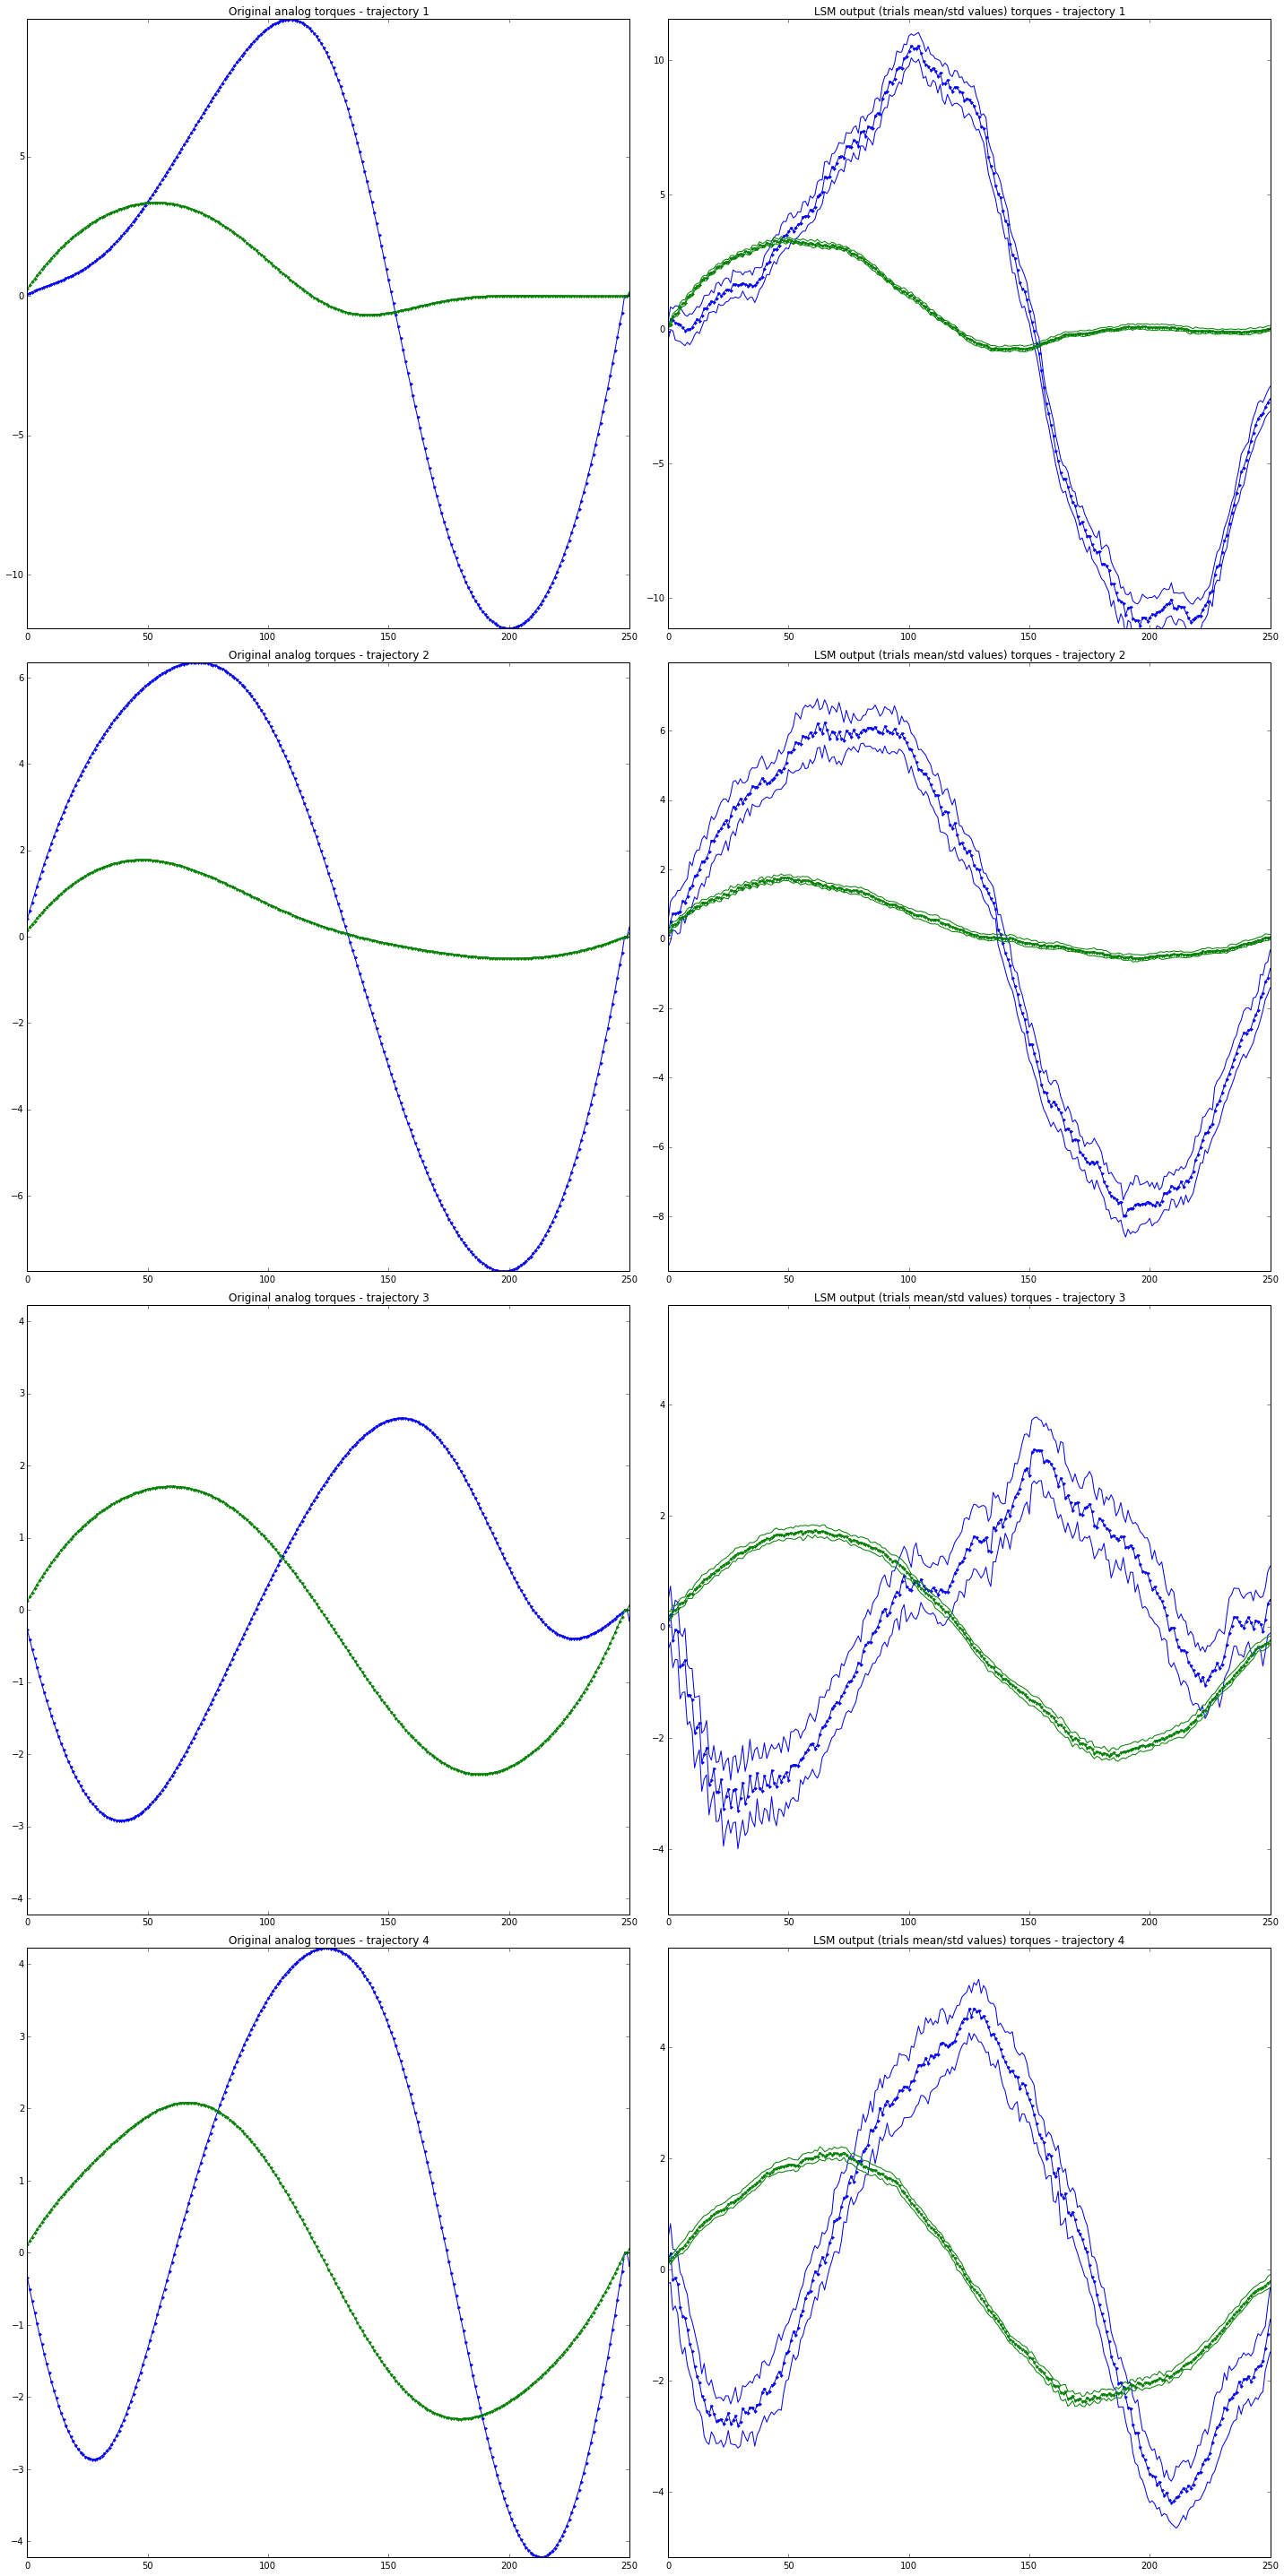

In [50]:
# Plots the inputs and the outputs side-by-side
# %matplotlib inline

offset11 = y_tau1.shape[0]/number_of_trajectories
offset21 = y_tau2.shape[0]/number_of_trajectories

offset12 = y_tau1.shape[0]/number_of_trajectories/total_trials
offset22 = y_tau2.shape[0]/number_of_trajectories/total_trials


fig=plt.figure(figsize =(20,40));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_tau1[trajectory*(total_trials*251):251*(1+trajectory*(total_trials*251))].max(),y_tau2[trajectory*(total_trials*251):251*(1+trajectory*(total_trials*251))].max()]).max()
    ymin=numpy.array([y_tau1[trajectory*(total_trials*251):251*(1+trajectory*(total_trials*251))].min(),y_tau2[trajectory*(total_trials*251):251*(1+trajectory*(total_trials*251))].min()]).min()

    ymaxLSM=numpy.array([y_tau1_calculated[trajectory*(total_trials*251):251*(1+trajectory*(total_trials*251))].max(),y_tau2_calculated[trajectory*(total_trials*251):251*(1+trajectory*(total_trials*251))].max()]).max()
    yminLSM=numpy.array([y_tau1_calculated[trajectory*(total_trials*251):251*(1+trajectory*(total_trials*251))].min(),y_tau2_calculated[trajectory*(total_trials*251):251*(1+trajectory*(total_trials*251))].min()]).min()


    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(y_tau1[trajectory*(offset11):offset11*trajectory+offset12],'.-')
    plt.plot(y_tau2[trajectory*(offset21):offset21*trajectory+offset22],'.-')

#     plt.plot(y_tau1[trajectory*(offset11):offset12*(1+trajectory*(total_trials*251))][:251],'.-')
#     plt.plot(y_tau2[trajectory*(offset21):offset22*(1+trajectory*(total_trials*251))][:251],'.-')

    plt.ylim(ymin,ymax)
    plt.title("Original analog torques - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    plt.plot(y_tau1_calculated.reshape(number_of_trajectories,total_trials,251)[trajectory,:,:].mean(axis=0),'b.-')
    plt.plot(y_tau1_calculated.reshape(number_of_trajectories,total_trials,251)[trajectory,:,:].mean(axis=0)+y_tau1_calculated.reshape(number_of_trajectories,total_trials,251)[trajectory,:,:].std(axis=0),'b')
    plt.plot(y_tau1_calculated.reshape(number_of_trajectories,total_trials,251)[trajectory,:,:].mean(axis=0)-y_tau1_calculated.reshape(number_of_trajectories,total_trials,251)[trajectory,:,:].std(axis=0),'b')    
    plt.plot(y_tau2_calculated.reshape(number_of_trajectories,total_trials,251)[trajectory,:,:].mean(axis=0),'g.-')
    plt.plot(y_tau2_calculated.reshape(number_of_trajectories,total_trials,251)[trajectory,:,:].mean(axis=0)+y_tau2_calculated.reshape(number_of_trajectories,total_trials,251)[trajectory,:,:].std(axis=0),'g')    
    plt.plot(y_tau2_calculated.reshape(number_of_trajectories,total_trials,251)[trajectory,:,:].mean(axis=0)-y_tau2_calculated.reshape(number_of_trajectories,total_trials,251)[trajectory,:,:].std(axis=0),'g')        
    plt.ylim(yminLSM,ymaxLSM)
    plt.title("LSM output (trials mean/std values) torques - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
plt.show()

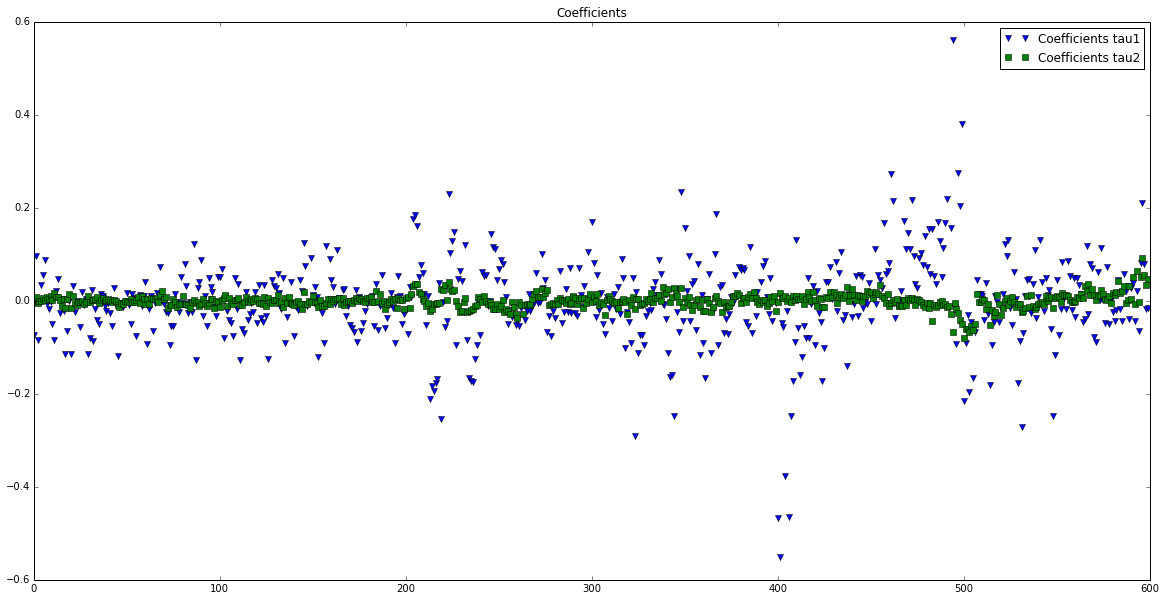

In [51]:
plt.rcParams['figure.figsize'] = 20, 10

plt.plot(c_tau1,'v',label="Coefficients tau1")
plt.plot(c_tau2,'s',label="Coefficients tau2")
plt.title("Coefficients")
plt.legend()
plt.show()

In [52]:
# Independent terms
r_tau1,r_tau2

(-0.047845260983706187, 0.19704564919643605)